# Project Description:

The purpose of this project is to implement a neural network that performs the translation of mathematical formulae from traditional **infix notation**—where the operator appears between two operands—to **postfix** (also known as Reverse Polish Notation), where the operator follows the operands.

Infix notation is the most commonly used in human-readable mathematics (e.g., a + b), but it is inherently ambiguous without additional syntactic aids such as parentheses or operator precedence rules. This ambiguity arises because different parse trees can correspond to the same expression depending on how operations are grouped.

In contrast, postfix notation eliminates the need for parentheses entirely. The order of operations is explicitly encoded by the position of the operators relative to the operands, making it more suitable for stack-based evaluation and easier to parse programmatically.

**Example:**

Consider the ambiguous infix expression:
a + b * c

This expression can be parsed in at least two different ways:

Interpretation (Infix):	(a + b) * c	   
Equivalent Postfix: ab+c*

Interpretation (Infix):	a + (b * c)	          
Equivalent Postfix: abc*+


This project aims to learn such disambiguations and generate the correct postfix form from a given infix expression using a data-driven approach based on neural networks. To simplify the task and control the complexity of expressions, we restrict our dataset to formulae with a maximum syntactic depth of 3. This means that the abstract syntax trees representing these expressions will have at most three levels, ensuring that the neural network operates on a bounded and manageable set of possible structures.

In [1]:
import numpy as np
import random
import string
import tensorflow as tf
from tensorflow.keras import layers, models
import matplotlib.pyplot as plt

2025-06-11 23:30:54.015132: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-06-11 23:30:54.023773: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1749677454.033432   33513 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1749677454.036323   33513 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1749677454.044724   33513 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking 

We build formulae using 5 identifiers a,b,c,d,e and 4 binary operators +,-,*,/.
For simplicity we do not take advantage of precedence or associativity rules for infix notation, and suppose that all binary operations as always fully parenthesizes: (e1 op e2).

In [2]:
# -------------------- Constants --------------------
OPERATORS = ['+', '-', '*', '/']
IDENTIFIERS = list('abcde')
SPECIAL_TOKENS = ['PAD', 'SOS', 'EOS']
SYMBOLS = ['(', ')', '+', '-', '*', '/']
VOCAB = SPECIAL_TOKENS + SYMBOLS + IDENTIFIERS + ['JUNK'] #may use junk in autoregressive generation

token_to_id = {tok: i for i, tok in enumerate(VOCAB)}
id_to_token = {i: tok for tok, i in token_to_id.items()}
VOCAB_SIZE = len(VOCAB)
PAD_ID = token_to_id['PAD']
EOS_ID = token_to_id['EOS']
SOS_ID = token_to_id['SOS']

MAX_DEPTH = 3
MAX_LEN = 4*2**MAX_DEPTH -2 #enough to fit expressions at given depth (+ EOS)

In [3]:
# -------------------- Expression Generation --------------------
def generate_infix_expression(max_depth):
    if max_depth == 0:
        return random.choice(IDENTIFIERS)
    elif random.random() < 0.5:
        return generate_infix_expression(max_depth - 1)
    else:
        left = generate_infix_expression(max_depth - 1)
        right = generate_infix_expression(max_depth - 1)
        op = random.choice(OPERATORS)
        return f'({left} {op} {right})'

def tokenize(expr):
    return [c for c in expr if c in token_to_id]

def infix_to_postfix(tokens):
    precedence = {'+': 1, '-': 1, '*': 2, '/': 2}
    output, stack = [], []
    for token in tokens:
        if token in IDENTIFIERS:
            output.append(token)
        elif token in OPERATORS:
            while stack and stack[-1] in OPERATORS and precedence[stack[-1]] >= precedence[token]:
                output.append(stack.pop())
            stack.append(token)
        elif token == '(':
            stack.append(token)
        elif token == ')':
            while stack and stack[-1] != '(':
                output.append(stack.pop())
            stack.pop()
    while stack:
        output.append(stack.pop())
    return output

def encode(tokens, max_len=MAX_LEN):
    ids = [token_to_id[t] for t in tokens] + [EOS_ID]
    return ids + [PAD_ID] * (max_len - len(ids))

def decode_sequence(token_ids, id_to_token, pad_token='PAD', eos_token='EOS'):
    """
    Converts a list of token IDs into a readable string by decoding tokens.
    Stops at the first EOS token if present, and ignores PAD tokens.
    """
    tokens = []
    for token_id in token_ids:
        token = id_to_token.get(token_id, '?')
        if token == eos_token:
            break
        if token != pad_token:
            tokens.append(token)
    return ' '.join(tokens)

def generate_dataset(n,max_depth=MAX_DEPTH):
    X, Y = [], []
    for _ in range(n):
        expr = generate_infix_expression(MAX_DEPTH)
        #expr = expr_gen.generate(max_depth=max_dthep)
        infix = tokenize(expr)
        postfix = infix_to_postfix(infix)
        X.append(encode(infix))
        Y.append(encode(postfix))
    return np.array(X), np.array(Y)

#you might use the shift function for teacher-forcing
def shift_right(seqs):
    shifted = np.zeros_like(seqs)
    shifted[:, 1:] = seqs[:, :-1]
    shifted[:, 0] = SOS_ID
    return shifted

Let us define a simple dataset, and inspect a few samples.

In [4]:
X_train, Y_train = generate_dataset(10000)
decoder_input_train = shift_right(Y_train)

# Dataset
X_val, Y_val = generate_dataset(1000)
decoder_input_val = shift_right(Y_val)

In [5]:
i =  np.random.randint(10000)
print(i)
print("infix : ",decode_sequence(X_train[i],id_to_token))
print("posfix notation: ",decode_sequence(Y_train[i],id_to_token))
print("teacher forcing : ", decode_sequence(decoder_input_train[i],id_to_token))

628
infix :  ( a - ( a / ( a - b ) ) )
posfix notation:  a a a b - / -
teacher forcing :  SOS a a a b - / -


# Constraints
* You may use any architecture (decoder-only, encoder-decoder, or other).

* The maximum number of parameters is 2 million.

* Beam search is not allowed.

* You may adapt the formula generator to your needs, but preserve its core logic—especially the frequency distribution of formulas by depth, as it may significantly influence model performance.

* You may train your model using a pre-generated fixed dataset (e.g., an array) or directly use an on-the-fly generator.




# Evaluation

We shall evaluate a generated item y_pred using "prefix accuracy", the lenght of
the initial prefix of y_pred matching the ground true y_true. This will be divided by the maximum length of y_true and y_pred (up to EOS), so that a perfect match has score 1.

* It's more informative than exact match (which is often 0)

* It’s tighter than edit distance: focuses on generation flow

* Captures where the model starts to make errors



In [6]:
def prefix_accuracy_single(y_true, y_pred, id_to_token, eos_id=EOS_ID, verbose=False):
    t_str = decode_sequence(y_true, id_to_token).split(' EOS')[0]
    p_str = decode_sequence(y_pred, id_to_token).split(' EOS')[0]
    t_tokens = t_str.strip().split()
    p_tokens = p_str.strip().split()
    max_len = max(len(t_tokens), len(p_tokens))

    match_len = sum(x == y for x, y in zip(t_tokens, p_tokens))
    score = match_len / max_len if max_len>0 else 0

    if verbose:
        print("TARGET :", ' '.join(t_tokens))
        print("PREDICT:", ' '.join(p_tokens))
        print(f"PREFIX MATCH: {match_len}/{len(t_tokens)} → {score:.2f}")

    return score

For the exam, evaluate you model on a test set of 20 expressions. Repeat this evaluation 10 times, and return the mean and std for this rounds.

## Model
For this project I decided to use a simple Transformer-based sequence-to-sequence model for the given task.

This architecture is optimal for this type of sequence-to-sequence task, as it can effectively learn the relationships between the input infix expressions and their corresponding postfix representations.

I implemented an encoder-decoder architecture which uses my class `PositionalEncoding` to add positional information to the input embeddings.

The model is built as follows:

**Encoder**:
- *Input Layer*: Accepts the tokenized infix expressions.
- *Embedding Layer*: Converts tokens into dense vectors.
- *Positional Encoding*: Adds positional information to the embeddings using the `PositionalEncoding` class.
- *Encoder Block(s)*:
    - Multi-Head Self-Attention
    - Feed Forward Network
    - Layer Normalization

**Decoder**:
- *Input Layer*: Accepts the tokenized postfix expressions.
- *Embedding Layer*: Converts tokens into dense vectors.
- *Positional Encoding*: Adds positional information to the embeddings using the `PositionalEncoding` class.
- *Decoder Block(s)*:
    - Multi-Head Self-Attention
    - Encoder-Decoder Attention
    - Feed Forward Network
    - Layer Normalization

**Output**:
- *Final Dense Layer*: Final Dense layer with softmax to produce the output tokens.
```python
# Create the model
model = create_transformer_model(
    vocab_size=VOCAB_SIZE,
    max_len=MAX_LEN,
    embedding_dim=64,  # embedding dimension
    num_heads=4,  # Number of attention heads
    feedforward_dimension=128,  # Feed-forward dimension
    num_encoder_layers=1,  # Number of encoder layers
    num_decoder_layers=1,  # Number of decoder layers
)
```
These parameters were chosen to keep the model within the 2 million parameter limit and as few as possible, while still allowing it to learn effectively from the dataset. Furthermore I tried different configurations of the model, such as varying the number of layers and attention heads, and found out that this configuration provided a good balance between complexity and performance. 

In [7]:
class PositionalEncoding(layers.Layer):
    """
    Positional Encoding Layer for adding positional information to input embeddings.
    """

    def __init__(self, max_len, d_model):
        super().__init__()
        self.d_model = d_model
        self.max_len = max_len

    def build(self, input_shape):
        # Create positional encoding matrix
        pe = np.zeros((self.max_len, self.d_model))
        position = np.arange(0, self.max_len)[:, np.newaxis]
        div_term = np.exp(
            np.arange(0, self.d_model, 2) * -(np.log(10000.0) / self.d_model)
        )

        pe[:, 0::2] = np.sin(position * div_term)
        pe[:, 1::2] = np.cos(position * div_term)

        self.pe = self.add_weight(
            name="positional_encoding",
            shape=(self.max_len, self.d_model),
            initializer="zeros",
            trainable=False,
        )
        self.pe.assign(pe)

    def call(self, x):
        seq_len = tf.shape(x)[1]
        return x + self.pe[:seq_len, :]


def create_transformer_model(
    vocab_size=VOCAB_SIZE,
    max_len=MAX_LEN,
    embedding_dim=64,
    num_heads=4,
    feedforward_dimension=128,
    num_encoder_layers=2,
    num_decoder_layers=2,
):
    """
    Create the Transformer model architecture.
    """

    # INPUTS
    encoder_inputs = layers.Input(shape=(max_len,), name="encoder_inputs")
    decoder_inputs = layers.Input(shape=(max_len,), name="decoder_inputs")

    # EMBEDDING + POSITIONAL ENCODING
    encoder_embedding = layers.Embedding(vocab_size, embedding_dim, mask_zero=True)(
        encoder_inputs
    )
    encoder_pos_encoding = PositionalEncoding(max_len, embedding_dim)(encoder_embedding)
    encoder_output = layers.Dropout(0.1)(encoder_pos_encoding)

    decoder_embedding = layers.Embedding(vocab_size, embedding_dim, mask_zero=True)(
        decoder_inputs
    )
    decoder_pos_encoding = PositionalEncoding(max_len, embedding_dim)(decoder_embedding)
    decoder_output = layers.Dropout(0.1)(decoder_pos_encoding)

    # ENCODER STACK
    for _ in range(num_encoder_layers):
        # Multi-head self-attention
        attn_out = layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=embedding_dim // num_heads, dropout=0.1
        )(encoder_output, encoder_output)
        attn_out = layers.Dropout(0.1)(attn_out)
        encoder_output = layers.LayerNormalization()(encoder_output + attn_out)

        # Feed-forward
        ffn = layers.Dense(feedforward_dimension, activation="relu")(encoder_output)
        ffn = layers.Dense(embedding_dim)(ffn)
        ffn = layers.Dropout(0.1)(ffn)
        encoder_output = layers.LayerNormalization()(encoder_output + ffn)

    # DECODER STACK
    for _ in range(num_decoder_layers):
        # Masked self-attention (causal)
        self_attn = layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=embedding_dim // num_heads, dropout=0.1
        )(decoder_output, decoder_output, use_causal_mask=True)
        self_attn = layers.Dropout(0.1)(self_attn)
        decoder_output = layers.LayerNormalization()(decoder_output + self_attn)

        # Cross-attention encoder->decoder
        cross_attn = layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=embedding_dim // num_heads, dropout=0.1
        )(decoder_output, encoder_output)
        cross_attn = layers.Dropout(0.1)(cross_attn)
        decoder_output = layers.LayerNormalization()(decoder_output + cross_attn)

        # Feed-forward
        ffn_dec = layers.Dense(feedforward_dimension, activation="relu")(decoder_output)
        ffn_dec = layers.Dense(embedding_dim)(ffn_dec)
        ffn_dec = layers.Dropout(0.1)(ffn_dec)
        decoder_output = layers.LayerNormalization()(decoder_output + ffn_dec)

    # OUTPUT LAYER
    outputs = layers.Dense(vocab_size, activation="softmax", dtype=tf.float32)(decoder_output)

    model = models.Model([encoder_inputs, decoder_inputs], outputs)
    return model


tf.keras.mixed_precision.set_global_policy("mixed_float16")  # Enable mixed precision to speed up training, -5s on average
# Check if GPU is available
gpus = tf.config.list_physical_devices("GPU")
if gpus:
    print("GPU available")
else:
    print("No GPU available, using CPU")

# Create the model
model = create_transformer_model(
    vocab_size=VOCAB_SIZE,
    max_len=MAX_LEN,
    embedding_dim=64,  # embedding dimension
    num_heads=4,  # Number of attention heads
    feedforward_dimension=128,  # Feed-forward dimension
    num_encoder_layers=1,  # Number of encoder layers
    num_decoder_layers=1,  # Number of decoder layers
)

# Summary
# model.summary()

# Compile the model
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"],
)

print(f"Total parameters: {model.count_params():,}")
print(f"Vocabulary size: {VOCAB_SIZE}")
print(f"Max sequence length: {MAX_LEN}")

GPU available


I0000 00:00:1749677455.566242   33513 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 5673 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 4060, pci bus id: 0000:01:00.0, compute capability: 8.9


Total parameters: 90,447
Vocabulary size: 15
Max sequence length: 30


/home/enrico/Desktop/Infix-to-postfix-notation/.venv/lib/python3.12/site-packages/keras/src/layers/layer.py:965: UserWarning: Layer 'positional_encoding' (of type PositionalEncoding) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(
/home/enrico/Desktop/Infix-to-postfix-notation/.venv/lib/python3.12/site-packages/keras/src/layers/layer.py:965: UserWarning: Layer 'positional_encoding_1' (of type PositionalEncoding) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(


## Training
In the next part of code I trained the model using the Adam optimizer with a learning rate of 0.001 and a batch size of 64 over a total of 50 epochs and `generate_dataset(MAX_DATASET_SIZE)` function to generate the dataset containing `MAX_DATASET_SIZE` samples, in this case I used 100,000 samples.


I also used an `EarlyStopping` callback to monitor the `accuracy` metric and stop the training if it does not improve for 3 consecutive epochs.

I used the `SparseCategoricalCrossentropy` loss function, which is suitable for sequence generation tasks where the target is a sequence of tokens.

I also used the `gdown` library to download the weights of the model from my own Google Drive, but you can also train the model yourself from scratch by just setting `LOAD_WEIGHTS` to false.


I uploaded on Google Drive at this [link](https://drive.google.com/uc?id=1XDBmXJ6WarbWKhmCDKrUEVB2yqDuQ-EZ) the weights of the model trained until epoch 47.

**Epoch 47 details**:
- **accuracy**: *0.9998*
- **loss**: *8.2848e-04*
- **val_accuracy**: *1.0000*
- **val_loss**: *1.6731e-05*


Training samples: 100000
Validation samples: 100000
Input shape: (100000, 30)
Output shape: (100000, 30)
Decoder input shape: (100000, 30)
Epoch 1/50


I0000 00:00:1749677466.485746   33568 service.cc:152] XLA service 0x783ed4001e70 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1749677466.485759   33568 service.cc:160]   StreamExecutor device (0): NVIDIA GeForce RTX 4060, Compute Capability 8.9
2025-06-11 23:31:06.582749: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2025-06-11 23:31:06.629650: W tensorflow/compiler/tf2xla/kernels/assert_op.cc:39] Ignoring Assert operator compile_loss/sparse_categorical_crossentropy/SparseSoftmaxCrossEntropyWithLogits/assert_equal_1/Assert/Assert
I0000 00:00:1749677467.161090   33568 cuda_dnn.cc:529] Loaded cuDNN version 90300
2025-06-11 23:31:08.444753: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_10', 4 bytes spill stores, 4

  78/1563 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.6705 - loss: 1.2664 

I0000 00:00:1749677475.766694   33568 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


1556/1563 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8868 - loss: 0.3447

2025-06-11 23:31:18.859495: W tensorflow/compiler/tf2xla/kernels/assert_op.cc:39] Ignoring Assert operator compile_loss/sparse_categorical_crossentropy/SparseSoftmaxCrossEntropyWithLogits/assert_equal_1/Assert/Assert
2025-06-11 23:31:20.542436: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_10', 184 bytes spill stores, 184 bytes spill loads

2025-06-11 23:31:20.720745: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_10', 4 bytes spill stores, 4 bytes spill loads

2025-06-11 23:31:22.465703: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_32', 4 bytes spill stores, 4 bytes spill loads

2025-06-11 23:31:22.473013: I external/local_xla/xla/stream_executor/cu

1563/1563 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.8871 - loss: 0.3437

2025-06-11 23:31:27.641126: W tensorflow/compiler/tf2xla/kernels/assert_op.cc:39] Ignoring Assert operator compile_loss/sparse_categorical_crossentropy/SparseSoftmaxCrossEntropyWithLogits/assert_equal_1/Assert/Assert
2025-06-11 23:31:29.152488: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_10_0', 8 bytes spill stores, 8 bytes spill loads

2025-06-11 23:31:29.275384: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_9', 8 bytes spill stores, 8 bytes spill loads

2025-06-11 23:31:29.510490: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_10', 44 bytes spill stores, 44 bytes spill loads

2025-06-11 23:31:31.719245: W tensorflow/compiler/tf2xla/kernels/assert_

1563/1563 ━━━━━━━━━━━━━━━━━━━━ 31s 12ms/step - accuracy: 0.8871 - loss: 0.3436 - val_accuracy: 0.9992 - val_loss: 0.0030
Epoch 2/50
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.9947 - loss: 0.0160 - val_accuracy: 1.0000 - val_loss: 2.9868e-04
Epoch 3/50
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.9971 - loss: 0.0090 - val_accuracy: 1.0000 - val_loss: 1.1522e-04
Epoch 4/50
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.9980 - loss: 0.0064 - val_accuracy: 1.0000 - val_loss: 7.8557e-05
Epoch 5/50
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.9984 - loss: 0.0050 - val_accuracy: 1.0000 - val_loss: 3.0051e-05
Epoch 6/50
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.9986 - loss: 0.0044 - val_accuracy: 1.0000 - val_loss: 4.9210e-05
Epoch 7/50
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.9989 - loss: 0.0037 - val_accuracy: 1.0000 - val_loss: 2.4259e-05
Epoch 8/50
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.9991 - 

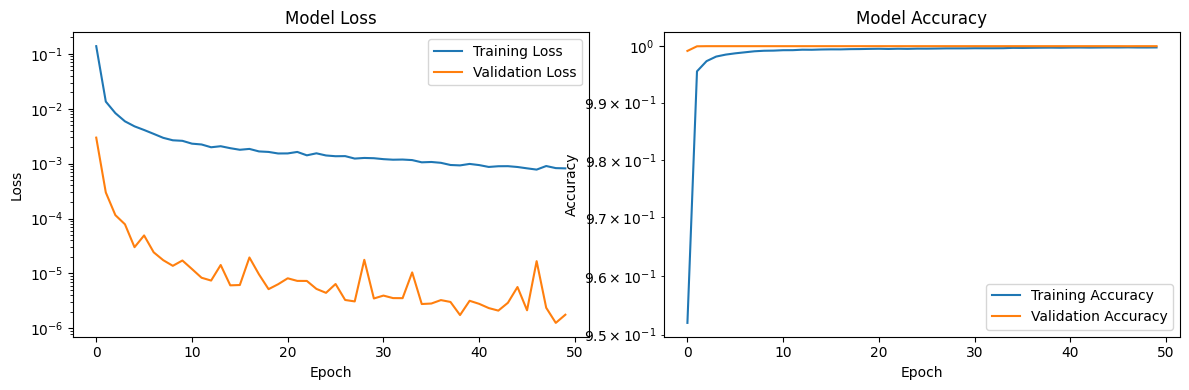

Final training loss: 0.0008
Final validation loss: 0.0000
Final training accuracy: 0.9998
Final validation accuracy: 1.0000


In [8]:
# Prepare training data
batch_size = 64
epochs = 50  # 50 epochs because we use early stopping
MAX_DATASET_SIZE = 100000  # Original size for full training

# Generate smaller dataset for initial testing
X_train, Y_train = generate_dataset(MAX_DATASET_SIZE)
decoder_input_train = shift_right(Y_train)

# Validation dataset
X_val, Y_val = generate_dataset(MAX_DATASET_SIZE)
decoder_input_val = shift_right(Y_val)

print(f"Training samples: {len(X_train)}")
print(f"Validation samples: {len(X_val)}")
print(f"Input shape: {X_train.shape}")
print(f"Output shape: {Y_train.shape}")
print(f"Decoder input shape: {decoder_input_train.shape}")

# Display model summary
# model.summary()

# Early stopping callback to prevent overfitting
from tensorflow.keras import callbacks

early_stop = callbacks.EarlyStopping(
    monitor="accuracy", patience=3, verbose=1, restore_best_weights=True
)

def make_dataset(X, decoder_input, Y, batch_size):
    dataset = tf.data.Dataset.from_tensor_slices(((X, decoder_input), Y))
    return dataset.shuffle(1024).batch(batch_size).prefetch(tf.data.AUTOTUNE)

train_dataset = make_dataset(X_train, decoder_input_train, Y_train, batch_size)
val_dataset = make_dataset(X_val, decoder_input_val, Y_val, batch_size)

LOAD_WEIGHTS = False  # If False, proceed to train the model

WEIGHTS_PATH = "transformer_model.weights.h5"

if LOAD_WEIGHTS:
    # Use gdown to download pre-trained weights
    import gdown
    import os

    WEIGHTS_URL = (
        "https://drive.google.com/uc?id=1XDBmXJ6WarbWKhmCDKrUEVB2yqDuQ-EZ"
    )
    if not os.path.exists(WEIGHTS_PATH):
        print("Pre-trained weights not found")
        gdown.download(WEIGHTS_URL, WEIGHTS_PATH, quiet=False)
    model.load_weights(WEIGHTS_PATH)
    print("Loaded pre-trained weights.")
else:
    # Train the model
    history = model.fit(
        train_dataset,
        validation_data=val_dataset,
        epochs=epochs,
        callbacks=[early_stop],
        verbose=1,
    )

    # Plot training history
    import matplotlib.pyplot as plt

    plt.figure(figsize=(12, 4))

    plt.subplot(1, 2, 1)
    plt.plot(history.history["loss"], label="Training Loss")
    plt.plot(history.history["val_loss"], label="Validation Loss")
    plt.title("Model Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.semilogy()  # Use semilogy for better visibility of loss
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(history.history["accuracy"], label="Training Accuracy")
    plt.plot(history.history["val_accuracy"], label="Validation Accuracy")
    plt.title("Model Accuracy")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.legend()
    plt.tight_layout()
    plt.semilogy()  # Use semilogy for better visibility of accuracy
    plt.show()

    print(f"Final training loss: {history.history['loss'][-1]:.4f}")
    print(f"Final validation loss: {history.history['val_loss'][-1]:.4f}")
    print(f"Final training accuracy: {history.history['accuracy'][-1]:.4f}")
    print(f"Final validation accuracy: {history.history['val_accuracy'][-1]:.4f}")

### Saving the model's weights
If you want to save the model's weights after training, you can use set `LOAD_WEIGHTS` to `True` and run the code below.

In [9]:
SAVE_WEIGHTS = True
# Save weights
if SAVE_WEIGHTS:
    model.save_weights(WEIGHTS_PATH)
    print(f"Model weights saved to '{WEIGHTS_PATH}'.")

Model weights saved to 'transformer_model.weights.h5'.


### Evaluation.
For the evaluation process I implemented the function `autoregressive_decode` which performs autoregressive decoding to generate the postfix expression from the infix expression. This function uses the trained model to predict the next token in the sequence until it reaches the end of the sequence (EOS) token.

In [10]:
def autoregressive_decode(model, encoder_input, max_len=MAX_LEN):
    """
    Autoregressively decode a sequence using the trained model.
    """
    encoder_input = np.expand_dims(encoder_input, axis=0)  # shape (1, seq_len)
    decoder_input = np.array([[SOS_ID]])  # start with SOS token

    for _ in range(max_len):
        predictions = model.predict([encoder_input, decoder_input], verbose=0)
        next_token_id = np.argmax(predictions[0, -1, :])  # get last token prediction
        if next_token_id == EOS_ID:  # stop if EOS is generated
            break
        decoder_input = np.append(decoder_input, [[next_token_id]], axis=1)

    return decoder_input[0]  # return as flat array of token IDs


### Results
In the following code I evaluate the model's performance on the given `test` function which returns excellent results:
- score: 1.0
- std: 0.0

This means that the model is able to generate the correct postfix expression for the given infix expression with a perfect match.

In [11]:
def test(no=20,rounds=10):
  rscores =[]
  for i in range(rounds):
    print("round=",i)
    X_test, Y_test = generate_dataset(no)
    scores = []
    for j in range(no):
      encoder_input=X_test[j]
      generated = autoregressive_decode(model, encoder_input)[1:] #remove SOS
      scores.append(prefix_accuracy_single(Y_test[j], generated, id_to_token))
    rscores.append(np.mean(scores))
  return np.mean(rscores),np.std(rscores)

res, std = test(20,10)
print("score=",res,"std=",std)

round= 0


/home/enrico/Desktop/Infix-to-postfix-notation/.venv/lib/python3.12/site-packages/keras/src/layers/layer.py:965: UserWarning: Layer 'positional_encoding' (of type PositionalEncoding) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(
/home/enrico/Desktop/Infix-to-postfix-notation/.venv/lib/python3.12/site-packages/keras/src/layers/layer.py:965: UserWarning: Layer 'positional_encoding_1' (of type PositionalEncoding) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(
/home/enrico/Desktop/Infix-to-postfix-notation/.venv/lib/python3.12/site-packages/keras/src/ops/nn.py:944: UserWarning: You are using a softmax over axis 3 of a tensor of shape (1, 4, 1, 1). This axis has size 1. The softmax operati

round= 1
round= 2
round= 3
round= 4
round= 5
round= 6
round= 7
round= 8
round= 9
score= 1.0 std= 0.0


Be sure to evalutate the generator: your model may only take as input the expression in infix format and return its translation to postifix.

If you are usuing an encoder-decoder model, generation must be done autoregressively.

# What to deliver

As usual you are supposed to deliver a single notebook witten in Keras. You are auhtorized to use Keras3 with pytorch as backend if your prefer.

Do no upload a zip file: the submission will be rejected.

The python notebook should have a clear documentation of the training phase, possibly with its history.

You should be able to provide the network paramters upon request. Even better, consider a way to upload them inside your notebook using gdown.